In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import decimal
import cv2

decimal.getcontext().prec = 100


def spherical_to_cartesian(spherical: np.array) -> np.array:
    x = spherical[:, 0] * np.sin(spherical[:, 1]) * np.cos(spherical[:, 2])
    y = spherical[:, 0] * np.sin(spherical[:, 1]) * np.sin(spherical[:, 2])
    z = spherical[:, 0] * np.cos(spherical[:, 1])
    return np.array([x, y, z])


def fit_plane(points):
    """
    Fits a plane to a set of 3D points using the least-squares method.

    Args:
        points (np.ndarray): An Nx3 matrix where each row is a point (x, y, z).

    Returns:
        (np.ndarray, float): Normal vector of the plane and distance from the origin.
    """
    points = np.asarray(points)
    assert points.shape[1] == 3, "Input points must be a Nx3 matrix."

    centroid = np.mean(points, axis=0)

    centered_points = points - centroid

    _, _, vh = np.linalg.svd(centered_points)

    normal_vector = vh[-1]

    d = -np.dot(normal_vector, centroid)

    return normal_vector, d


def generate_plane(normal, d, centroid, size=10, step=1):
    """
    Generates a grid of points to visualize the fitted plane.
    """
    # Create a grid of points around the centroid
    x_range = np.arange(centroid[0] - size, centroid[0] + size, step)
    y_range = np.arange(centroid[1] - size, centroid[1] + size, step)
    x, y = np.meshgrid(x_range, y_range)

    # Plane equation: ax + by + cz + d = 0 -> z = (-d - ax - by) / c
    a, b, c = normal
    z = (-d - a * x - b * y) / c

    return np.stack((x, y, z), axis=-1)


def visualize(points, plane_x, plane_y, plane_z):
    """
    Visualizes 3D points and a fitted plane using Matplotlib.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        points[:, 0], points[:, 1], points[:, 2], color="r", label="Electron Points"
    )

    ax.plot_surface(
        plane_x, plane_y, plane_z, alpha=0.5, color="blue", label="Fitted Plane"
    )

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Plane Fitting Visualization")
    ax.legend()
    plt.show()

def point_to_plane_distance(point, normal, d):
    """
    Calculates the perpendicular distance from a point to a plane.

    Parameters:
        point (array-like): The coordinates of the point [x, y, z].
        normal (array-like): The normal vector of the plane [a, b, c].
        d (float): The distance from the origin to the plane.

    Returns:
        float: The perpendicular distance from the point to the plane.
    """
    point = np.asarray(point)
    normal = np.asarray(normal)

    numerator = np.abs(np.dot(normal, point) + d)

    denominator = np.linalg.norm(normal)

    return numerator / denominator


def project_onto_plane(points, normal, point_on_plane):
    """
    Projects 3D points onto a plane defined by a normal vector and a point on the plane.

    Args:
        points (ndarray): Array of 3D points (N x 3).
        normal (ndarray): Normal vector of the plane (1 x 3).
        point_on_plane (ndarray): A point on the plane (1 x 3).

    Returns:
        ndarray: Projected 3D points (N x 3).
    """
    normal = normal / np.linalg.norm(normal)
    projections = []
    for p in points:
        vector = p - point_on_plane
        distance = np.dot(vector, normal)
        projection = p - distance * normal
        projections.append(projection)
    return np.array(projections)


def rotate_to_z_plane(points, plane_normal):
    """
    Rotates 3D points to align with the z=0 plane.

    Args:
        points (ndarray): Array of 3D points (N x 3).
        plane_normal (ndarray): Normal vector of the plane (1 x 3).

    Returns:
        ndarray: Rotated 3D points (N x 3).
    """
    plane_normal = plane_normal / np.linalg.norm(plane_normal)
    target_normal = np.array([0, 0, 1])

    rotation_axis = np.cross(plane_normal, target_normal)
    rotation_angle = np.arccos(np.dot(plane_normal, target_normal))

    rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)

    # Create the rotation matrix using Rodrigues' rotation formula
    K = np.array(
        [
            [0, -rotation_axis[2], rotation_axis[1]],
            [rotation_axis[2], 0, -rotation_axis[0]],
            [-rotation_axis[1], rotation_axis[0], 0],
        ]
    )
    I = np.eye(3)
    R = I + np.sin(rotation_angle) * K + (1 - np.cos(rotation_angle)) * np.dot(K, K)

    rotated_points = np.dot(points, R.T)
    return rotated_points


def cartesian_to_polar(cartesian: np.array) -> np.array:
    r = np.linalg.norm(cartesian, axis=1)
    theta = np.arctan2(cartesian[:, 1], cartesian[:, 0])
    return np.array([r, theta]).T


def spherical_to_polar(spherical: np.array) -> np.array:
    points = spherical_to_cartesian(spherical).T
    print(points.shape)

    _, _, vh = np.linalg.svd(points[:2000])
    normal = vh[-1]
    point_on_plane = np.mean([points[0], points[-1]], axis=0)
    projected_points = project_onto_plane(points, normal, point_on_plane)
    rotated_points = rotate_to_z_plane(projected_points, normal)
    polar = cartesian_to_polar(rotated_points)

    return polar


def compute_cos_psi(phi, theta, sin_0, cos_0):
    return sin_0 * np.sin(theta) * np.cos(phi) + cos_0 * np.cos(theta)


def compute_psi_dot(theta_dot, theta, phi_dot):
    return np.sqrt(
        theta_dot * theta_dot + np.sin(theta) * np.sin(theta) * phi_dot * phi_dot
    )

def compute_sin_theta_0(k, m):
    return m / k

def compute_cos_theta_0(k, m):
    return np.sqrt(k * k - m * m) / k

In [2]:
sphere_3_2_1_d31 = pd.read_csv('sphere_3_2_1_d31.csv')

In [19]:
sin_0 = compute_sin_theta_0(2, 1)
cos_0 = compute_cos_theta_0(2, 1)
cos_psi_3_2_1_d31 = compute_cos_psi(sphere_3_2_1_d31['phi'], sphere_3_2_1_d31['theta'], sin_0, cos_0)

In [23]:
polar_3_2_d19 = pd.read_csv('polar_3_2_d19.csv')

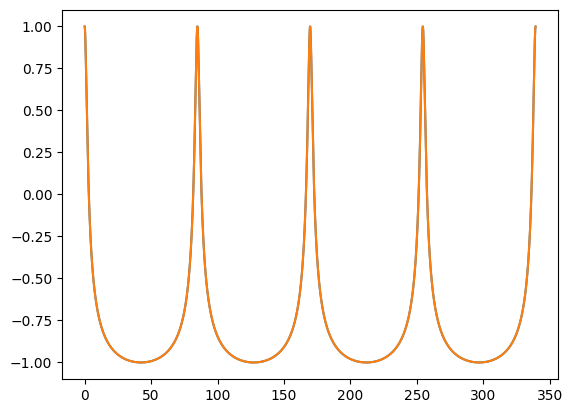

In [25]:
plt.plot(sphere_3_2_1_d31['t'], cos_psi_3_2_1_d31)
plt.plot(polar_3_2_d19['t'], np.cos(polar_3_2_d19['phi']))

In [26]:
df_cos_psi_3_2_1_d31 = cos_psi_3_2_1_d31 - np.cos(polar_3_2_d19['phi'])

Text(0, 0.5, '$cos(\\psi_{3D}) - cos(\\psi_{2D})$')

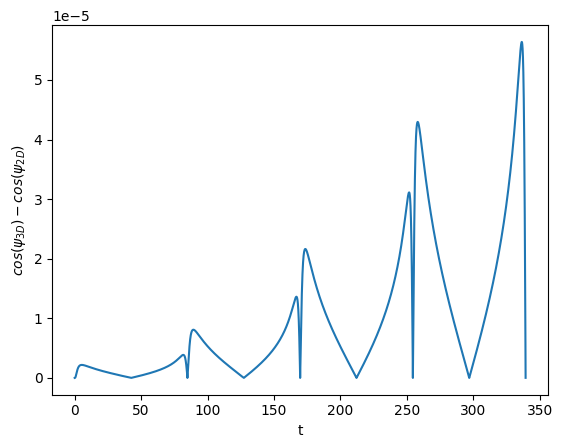

In [29]:
plt.plot(sphere_3_2_1_d31['t'], np.abs(df_cos_psi_3_2_1_d31))
plt.xlabel('t')
plt.ylabel('$cos(\\psi_{3D}) - cos(\\psi_{2D})$')

In [31]:
psi_dot_3_2_1_d31 = compute_psi_dot(sphere_3_2_1_d31['theta_dot'], sphere_3_2_1_d31['theta'], sphere_3_2_1_d31['phi_dot'])

In [34]:
df_psi_dot_3_2_1_d31 = psi_dot_3_2_1_d31 - polar_3_2_d19['phi_dot']

Text(0, 0.5, '$\\dot{\\psi}_{3D} - \\dot{\\psi}_{2D}$')

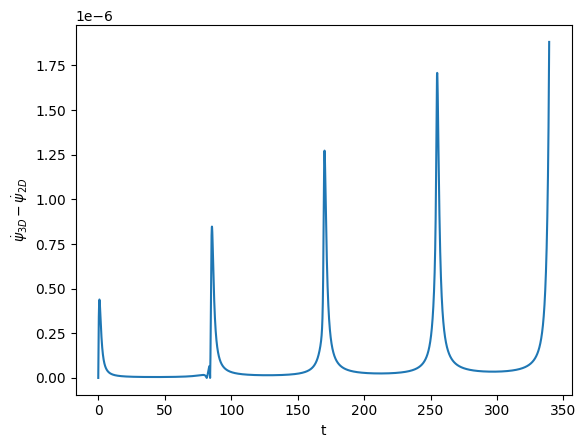

In [37]:
plt.plot(sphere_3_2_1_d31['t'], np.abs(df_psi_dot_3_2_1_d31))
plt.xlabel('t')
plt.ylabel('$\\dot{\\psi}_{3D} - \\dot{\\psi}_{2D}$')